# Netflix Movies and TV Shows
<div style="color:#140033;
           display:fill;
           border-radius:15px;
            border-style: solid;
           border-width: 15px;
            border-color:#f0e6ff;
           background-color:#f0e6ff;
           letter-spacing:0.75px;
            font-family:'Futura';
            line-height: 1.7em;
            font-size:1.3em;">
    
<h2><b>Context</b></h2><h4 style = "line-height:1.3;">
    This notebook deals with <a href = 'https://www.kaggle.com/shivamb/netflix-shows'>Netflix movies and TV shows</a> data which focuses on Exploratory data analysis. I tried to implement movie recommendation system using Cosine Similarity. Your feedbacks and appreciations are welcome.</h4>

</div>


<div style="color:#001724;
           display:fill;
           border-radius:50px;
            border-style: solid;
            padding: 25px 25px;
           border-width: 15px;
            border-color:#001724;
           background-color:#d0e7f5;
           letter-spacing:1.1px;
            font-family:'Futura';
            line-height: 1.7em;
            font-size:1.3em;">
    <h3 style = "line-height:1.5;"><b>TV Shows and Movies listed on Netflix</b></h3>
    <h4 style = "line-height:1.3;">
This dataset consists of tv shows and movies available on Netflix as of 2019. The dataset is collected from Flixable which is a third-party Netflix search engine.

In 2018, they released an interesting report which shows that the number of TV shows on Netflix has nearly tripled since 2010. The streaming service’s number of movies has decreased by more than 2,000 titles since 2010, while its number of TV shows has nearly tripled. It will be interesting to explore what all other insights can be obtained from the same dataset.

Integrating this dataset with other external datasets such as IMDB ratings, rotten tomatoes can also provide many interesting findings.</h4>
<h2><b>Motivation</b></h2>
<h3>Tasks which can be performed on this dataset -</h3>
<ul>
    <li>Understanding what content is available in different countries</li>
    <li>Identifying similar content by matching text-based features</li>
    <li>Network analysis of Actors / Directors and find interesting insights</li>
    <li>Is Netflix has increasingly focusing on TV rather than movies in recent years?</li>
</ul>
</div>

In [2]:
#Import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import time
import seaborn as sns
import re
import math
sns.set_style("whitegrid")
#sns.set(style="darkgrid")
sns.set_palette("tab10")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
import datetime as dt
plt.style.use('seaborn-notebook')
params = {'legend.fontsize': 15,
          'legend.title_fontsize': 16,
          'figure.figsize': (15, 5),
         'axes.labelsize': 18,
         'axes.titlesize':20,
         'xtick.labelsize':18,
         'ytick.labelsize':18}
plt.rcParams.update(params)
img_fmt = 'svg'

In [3]:
#Analysing the input dataframe
df=pd.read_csv('/kaggle/input/netflix-shows/netflix_titles.csv')
df.head()
df.info()
df.describe().T

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


,count,mean,std,min,25%,50%,75%,max
release_year,7787.0,2013.93258,8.757395,1925.0,2013.0,2017.0,2018.0,2021.0


# Data Preparation

In [4]:
df['release_year'] = pd.to_datetime(df['release_year'],format='%Y')
df['date_added'] = pd.to_datetime(df['date_added'])
indeks = df[np.isnan(df['date_added'])].index
df.loc[indeks, 'date_added'] = df.loc[indeks, 'release_year']
df['release_year'] = df['release_year'].dt.year

# Exploratory Data Analysis
## Content type on Netflix

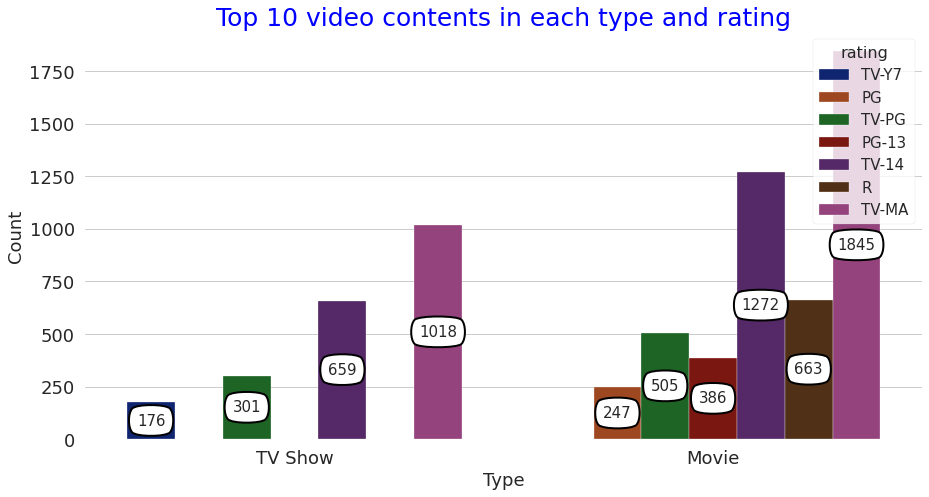

In [5]:
title = 'Top 10 video contents in each type and rating'
df_type_rating = df.groupby(['type','rating']).count().show_id.reset_index().sort_values(by = 'show_id').tail(10)
fig,ax = plt.subplots(figsize = (15,7.5))
plots = sns.barplot(data = df_type_rating, x='type',y = 'show_id', hue = 'rating', palette='dark')
for bar in plots.patches:
    _ = plots.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height() - (bar.get_height()-3.1)/2), ha='center', va='center',
                   size=15, xytext=(0, 0),bbox=dict(boxstyle="round4,pad=0.6", fc="w", ec="black", lw=2),
                   textcoords='offset points')
_ = plt.box(on=None)
_ = plt.title(title, fontsize = 25, color = 'blue')
_ = plt.xlabel('Type')
_ = plt.ylabel('Count')
_ = plt.savefig(title+'.'+img_fmt,format = img_fmt)

<div style="color:#001724;
           display:fill;
           border-radius:50px;
            border-style: solid;
            padding: 25px 25px;
           border-width: 15px;
            border-color:#001724;
           background-color:#d0e7f5;
           letter-spacing:1.1px;
            font-family:'Futura';
            line-height: 1.7em;
            font-size:1.3em;">
    <h3 style = "line-height:1.3;">Top 10 video contents by its type and rating is listed here. We can say that TV rating video contents are more prevalent in Netflix and R rated videos are all movie contents</h3>
</div>

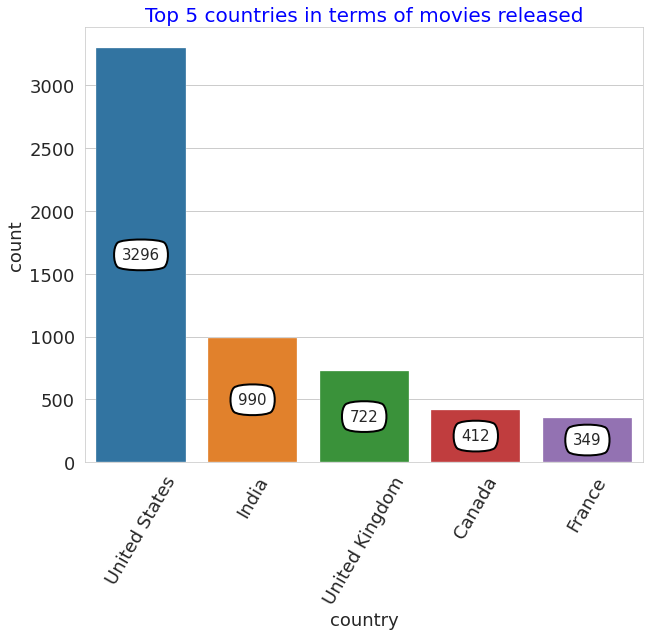

In [6]:
title = 'Top 5 countries in terms of movies released'
countries = {}
for country in df.country.dropna():
    for sub_country in str(country).split(', '):
        if sub_country not in countries:
            countries[sub_country] = 1
        else: countries[sub_country] += 1
df_countries = pd.DataFrame(list(countries.items()),columns = ['country','count']).sort_values(by = ['count'])
_ = plt.subplots(figsize = (10,8))
_ = plt.xticks(rotation = 60)
_ = plt.title(title, color='blue', fontsize=20)
plots = sns.barplot(data = df_countries.tail()[::-1],x= 'country', y='count')
for bar in plots.patches:
    _ = plots.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height() - (bar.get_height()-3.1)/2), ha='center', va='center',
                   size=15, xytext=(0, 0),bbox=dict(boxstyle="round4,pad=0.6", fc="w", ec="black", lw=2),
                   textcoords='offset points')
_ = plt.savefig(title+'.'+img_fmt,format = img_fmt)

<div style="color:#001724;
           display:fill;
           border-radius:50px;
            border-style: solid;
            padding: 25px 25px;
           border-width: 15px;
            border-color:#001724;
           background-color:#d0e7f5;
           letter-spacing:1.1px;
            font-family:'Futura';
            line-height: 1.7em;
            font-size:1.3em;">
    <h3 style = "line-height:1.3;">United states tops the productivity count with a huge margin nearly thrice the movie contents presented from the second best India.</h3>
</div>

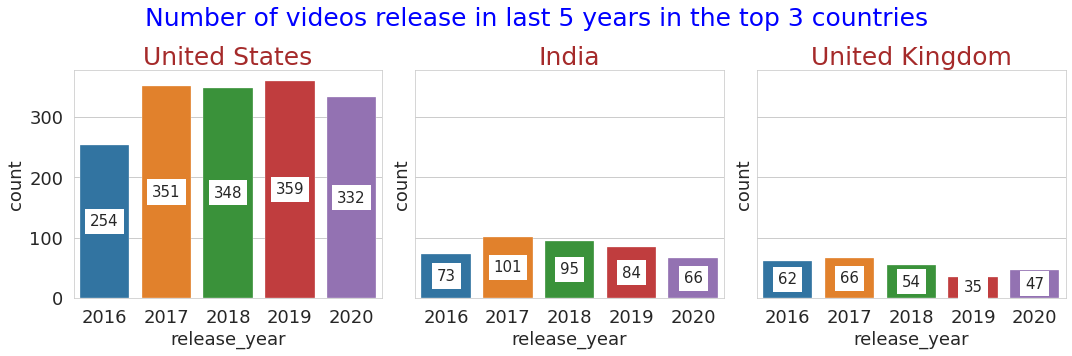

In [7]:
title = 'Number of videos release in last 5 years in the top 3 countries'
fig,ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5),sharey=True)
_ = fig.suptitle(title, fontsize = 25, color = 'blue')
i = 0
for country in df_countries.tail(3).country.values[::-1]:
    df_country = df.loc[df.country == country].loc[(df.release_year>2015) & (df.release_year<=2020)]
    plots = sns.countplot(data = df_country,x= 'release_year', ax = ax[i])
    _ = ax[i].set_title(country,color='brown', fontsize=25)
    for bar in plots.patches:
        _ = plots.annotate(format(bar.get_height(), '.0f'), 
                       (bar.get_x() + bar.get_width() / 2, 
                        bar.get_height()/2), ha='center', va='center',
                       size=15, xytext=(0, 0),bbox=dict(fc="w", ec="white", lw=2),
                       textcoords='offset points')
    i += 1
fig.tight_layout()
_ = plt.savefig(title+'.'+img_fmt,format = img_fmt)

<div style="color:#001724;
           display:fill;
           border-radius:50px;
            border-style: solid;
            padding: 25px 25px;
           border-width: 15px;
            border-color:#001724;
           background-color:#d0e7f5;
           letter-spacing:1.1px;
            font-family:'Futura';
            line-height: 1.7em;
            font-size:1.3em;">
    <h3 style = "line-height:1.3;">The number of video uploads per year remains steady for past 4 years in all the top 3 countries except the considerable increase during the year 2017</h3>
</div>

## Number of programmes released by year

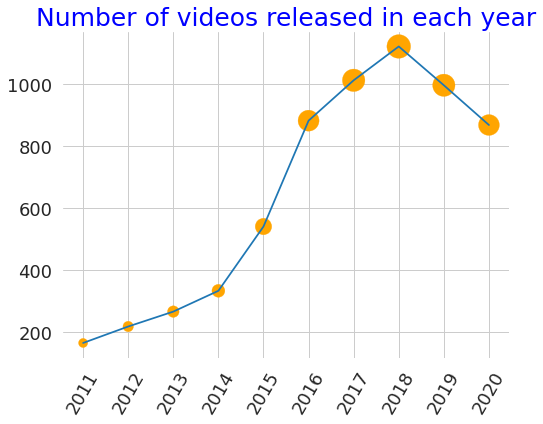

In [8]:
release = df['release_year'].value_counts()
release = release.sort_index(ascending=True)

title = 'Number of videos released in each year'
_ = plt.figure(figsize=(8,6))
_ = plt.plot(release[-11:-1])
_ = plt.scatter(release[-11:-1].index, release[-11:-1].values, s=0.5*release[-11:-1].values, c='orange');
_ = plt.box(on=None);
_ = plt.xticks(rotation = 60)
_ = plt.xticks(release[-11:-1].index);
_ = plt.title(title, color='blue', fontsize=25);
_ = plt.savefig(title+'.'+img_fmt,format = img_fmt)

<div style="color:#001724;
           display:fill;
           border-radius:50px;
            border-style: solid;
            padding: 25px 25px;
           border-width: 15px;
            border-color:#001724;
           background-color:#d0e7f5;
           letter-spacing:1.1px;
            font-family:'Futura';
            line-height: 1.7em;
            font-size:1.3em;">
    <h3 style = "line-height:1.3;">There is an increasing trend starting from the year 2011 and the trend starts to seetle with some dip in the movies counts post 2018.
It shows that most number of videos got released in 2018 comparatively higher than 2019 and 2020. </h3>
</div>

# Number of programmes by Rating

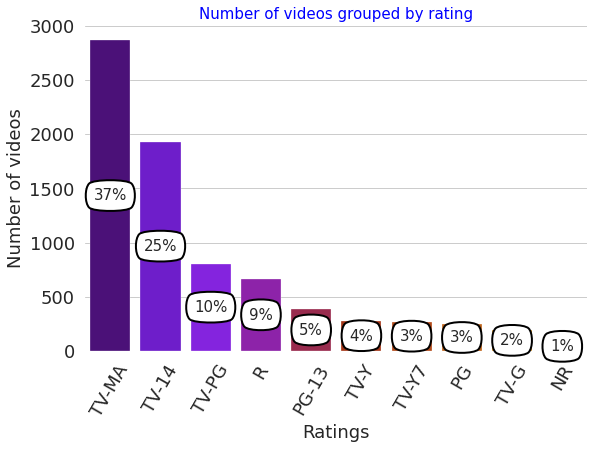

In [9]:
rating = df['rating'].value_counts()
#rating = rating.sort_values()

title = 'Number of videos grouped by rating'
_ = plt.figure(figsize=(9,6));
_ = plt.title(title, color='blue', fontsize=15)
plots = sns.barplot(y=rating.values[:10], x=rating.index[:10], palette='gnuplot',orient='v');
for bar in plots.patches:
    _ = plots.annotate(format(bar.get_height()/rating.sum()*100, '.0f')+'%', 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height() - (bar.get_height()-3.1)/2), ha='center', va='center',
                   size=15, xytext=(0, 0),bbox=dict(boxstyle="round4,pad=0.6", fc="w", ec="black", lw=2),
                   textcoords='offset points')
_ = plt.box(on=None)
_ = plt.xlabel('Ratings')
_ = plt.xticks(rotation = 60)
_ = plt.ylabel('Number of videos')
_ = plt.savefig(title+'.'+img_fmt,format = img_fmt)

<div style="color:#001724;
           display:fill;
           border-radius:50px;
            border-style: solid;
            padding: 25px 25px;
           border-width: 15px;
            border-color:#001724;
           background-color:#d0e7f5;
           letter-spacing:1.1px;
            font-family:'Futura';
            line-height: 1.7em;
            font-size:1.3em;">
    <h3 style = "line-height:1.3;">More than 70% videos are TV rated with TV-MA amounting for the most.</h3>
</div>

# Most Popular Programmes by Country & Rating

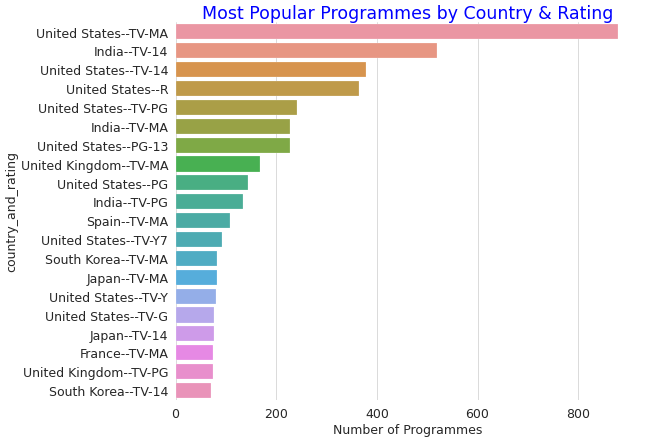

In [10]:
country_rating = df.groupby(['country', 'rating']).count().sort_values('show_id', ascending=False).reset_index()
country_rating['country_and_rating'] = country_rating[['country','rating']].apply(axis=1,func = lambda x : str(x.country)+'--'+str(x.rating))
country_rating.set_index(keys = 'country_and_rating', inplace = True)

title = 'Most Popular Programmes by Country & Rating'
_ = plt.figure(figsize=(12,10), dpi = 50)
plots = sns.barplot(y=country_rating.index[:20], x = country_rating['show_id'][:20]);
_ = plt.box(on=None)
_ = plt.title(title, fontsize=25, color='blue')
_ = plt.xlabel('Number of Programmes');
_ = plt.savefig(title+'.'+img_fmt,format = img_fmt)

<div style="color:#001724;
           display:fill;
           border-radius:50px;
            border-style: solid;
            padding: 25px 25px;
           border-width: 15px;
            border-color:#001724;
           background-color:#d0e7f5;
           letter-spacing:1.1px;
            font-family:'Futura';
            line-height: 1.7em;
            font-size:1.3em;">
    <h3 style = "line-height:1.3;">A Similar chart as we have seen before but with a additional dimension country is added to it. TV rated content accounts for the most as before. One interesting insight that we can grab is TV-MA is most popular than TV-14 in States and its a vice versa in India.</h3>
</div>

# Analysis on Movie Programmes

## Movies by Rating

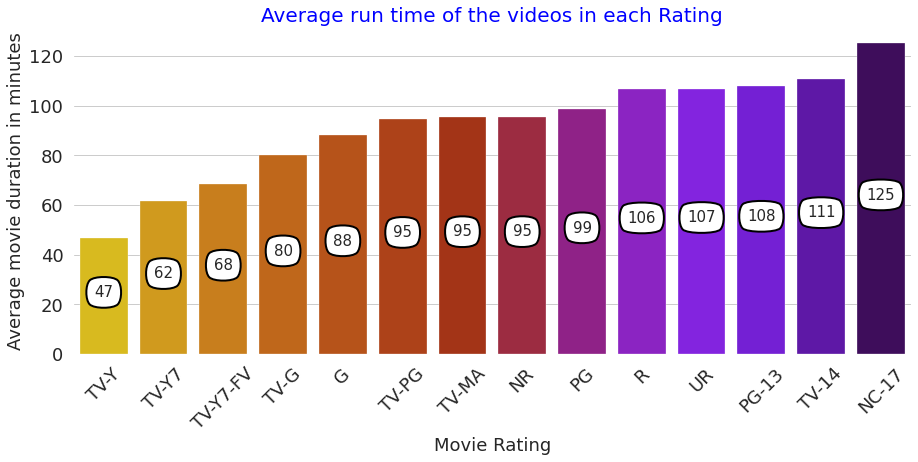

In [11]:
movie = df.copy()
movie = movie[movie['type'] == 'Movie']

movie['minute'] = [int(re.findall('\d{1,3}', w)[0]) for w in movie.duration.ravel()]

duration_rating = movie.groupby(['rating']).mean().sort_values('minute')
title = 'Average run time of the videos in each Rating'
_ = plt.figure(figsize=(15,6))
plots = sns.barplot(x=duration_rating.index, y=duration_rating.minute.values, palette='gnuplot_r')
for bar in plots.patches:
    _ = plots.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height() - (bar.get_height()-3.1)/2), ha='center', va='center',
                   size=15, xytext=(0, 0),bbox=dict(boxstyle="round4,pad=0.6", fc="w", ec="black", lw=2),
                   textcoords='offset points')
_ = plt.box(on=None)
_ = plt.title(title, fontsize = 20, color = 'blue')
_ = plt.xlabel('Movie Rating')
_ = plt.xticks(rotation = 45)
_ = plt.ylabel('Average movie duration in minutes')
_ = plt.savefig(title+'.'+img_fmt,format = img_fmt)

# Movie's Duration Trends

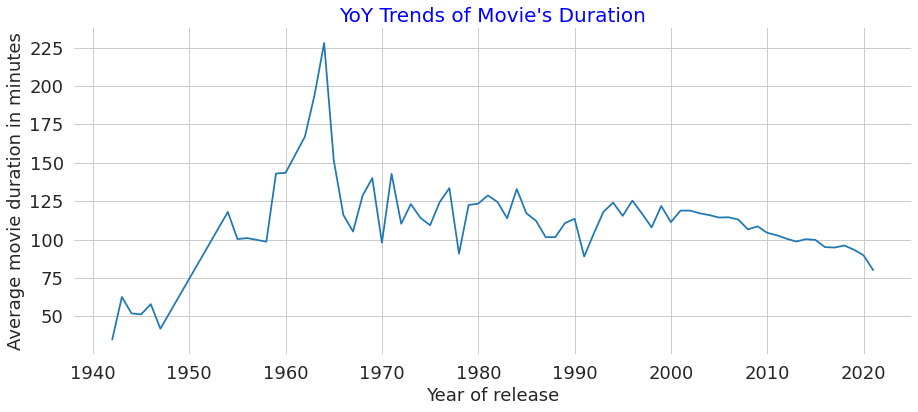

In [12]:
duration_year = movie.groupby(['release_year']).mean().sort_values('minute')
duration_year = duration_year.sort_index()

title = "YoY Trends of Movie's Duration"
_ = plt.figure(figsize=(15,6))
_ = sns.lineplot(x=duration_year.index, y=duration_year.minute.values)
_ = plt.box(on=None)
_ = plt.ylabel('Average movie duration in minutes');
_ = plt.xlabel('Year of release');
_ = plt.title(title, fontsize=20, color='blue');
_ = plt.savefig(title+'.'+img_fmt,format = img_fmt)

<div style="color:#001724;
           display:fill;
           border-radius:50px;
            border-style: solid;
            padding: 25px 25px;
           border-width: 15px;
            border-color:#001724;
           background-color:#d0e7f5;
           letter-spacing:1.1px;
            font-family:'Futura';
            line-height: 1.7em;
            font-size:1.3em;">
    <h3 style = "line-height:1.3;">The average movie's duration released during 1960 era was the longest </h3>
</div>

# Director's Productivity by Total Minutes of Movies Produced

Text(0.5, 0, 'Length of Total Movies Released in Minutes')

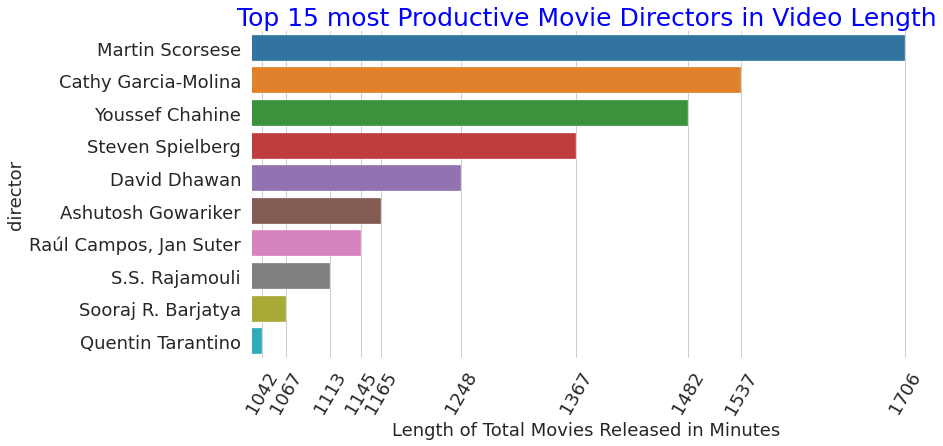

In [13]:
director_minute = movie.groupby('director').sum().sort_values('minute', ascending=False)
title = 'Top 15 most Productive Movie Directors in Video Length'
_ = plt.figure(figsize=(12,6))
_ = sns.barplot(y=director_minute.index[:10], x=director_minute.minute[:10]);
_ = plt.title(title, color='blue', fontsize=25)
_ = plt.xticks(director_minute.minute[:10],rotation = 60)
_ = plt.xlim(min(director_minute.minute[:10])/10*9.9,max(director_minute.minute[:10])/10*10.1)
_ = plt.box(on=None)
plt.xlabel('Length of Total Movies Released in Minutes');
_ = plt.savefig(title+'.'+img_fmt,format = img_fmt)

<div style="color:#001724;
           display:fill;
           border-radius:50px;
            border-style: solid;
            padding: 25px 25px;
           border-width: 15px;
            border-color:#001724;
           background-color:#d0e7f5;
           letter-spacing:1.1px;
            font-family:'Futura';
            line-height: 1.7em;
            font-size:1.3em;">
    <h3 style = "line-height:1.3;">Although Raul Campos produced more Movies, Martin Scorcece still outperform Raul in terms of the total duration of the movies </h3>
</div>

# The Most Productive Director by number of movies produced

Text(0.5, 0, 'Count of Total Movies Released')

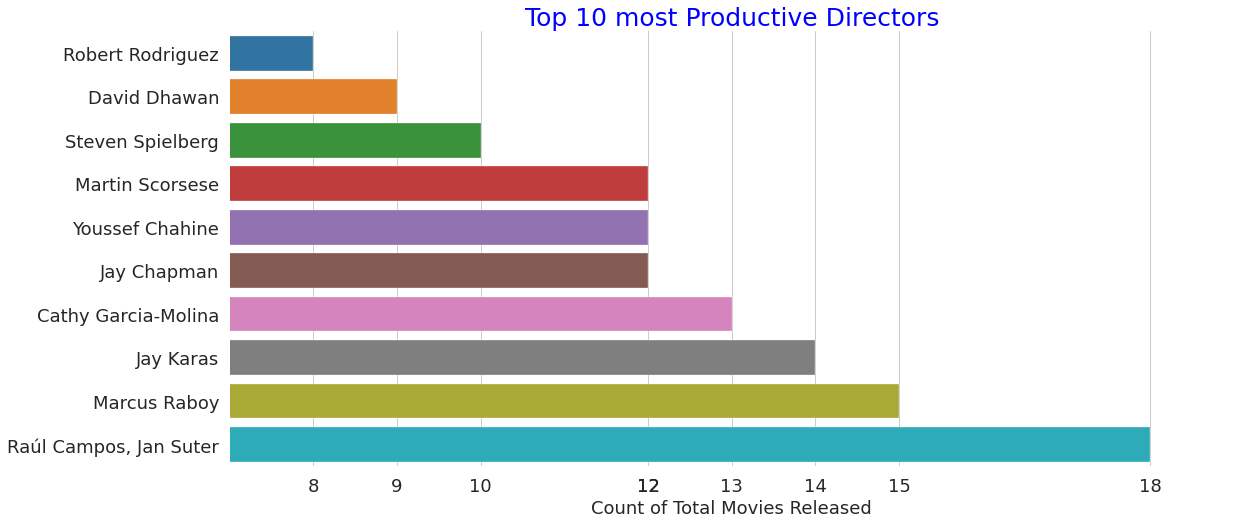

In [14]:
title = 'Top 10 most Productive Directors'
_ = plt.figure(figsize=(18,8))
_ = sns.barplot(y=movie.director.value_counts()[:10].sort_values().index, x=movie.director.value_counts()[:10].sort_values().values);
_ = plt.title(title, color='blue', fontsize=25)
_ = plt.box(on=None)
_ = plt.xticks(movie.director.value_counts()[:10].sort_values().values);
_ = plt.xlim(min(movie.director.value_counts()[:10])-1,max(movie.director.value_counts()[:10])+1)
plt.xlabel('Count of Total Movies Released');
_ = plt.savefig(title+'.'+img_fmt,format = img_fmt)

<div style="color:#001724;
           display:fill;
           border-radius:50px;
            border-style: solid;
            padding: 25px 25px;
           border-width: 15px;
            border-color:#001724;
           background-color:#d0e7f5;
           letter-spacing:1.1px;
            font-family:'Futura';
            line-height: 1.7em;
            font-size:1.3em;">
    <h3 style = "line-height:1.3;">Raul Campos and Jan Sutler have been credited as Directors in the record 18 videos 3 more than the second best. </h3>
</div>

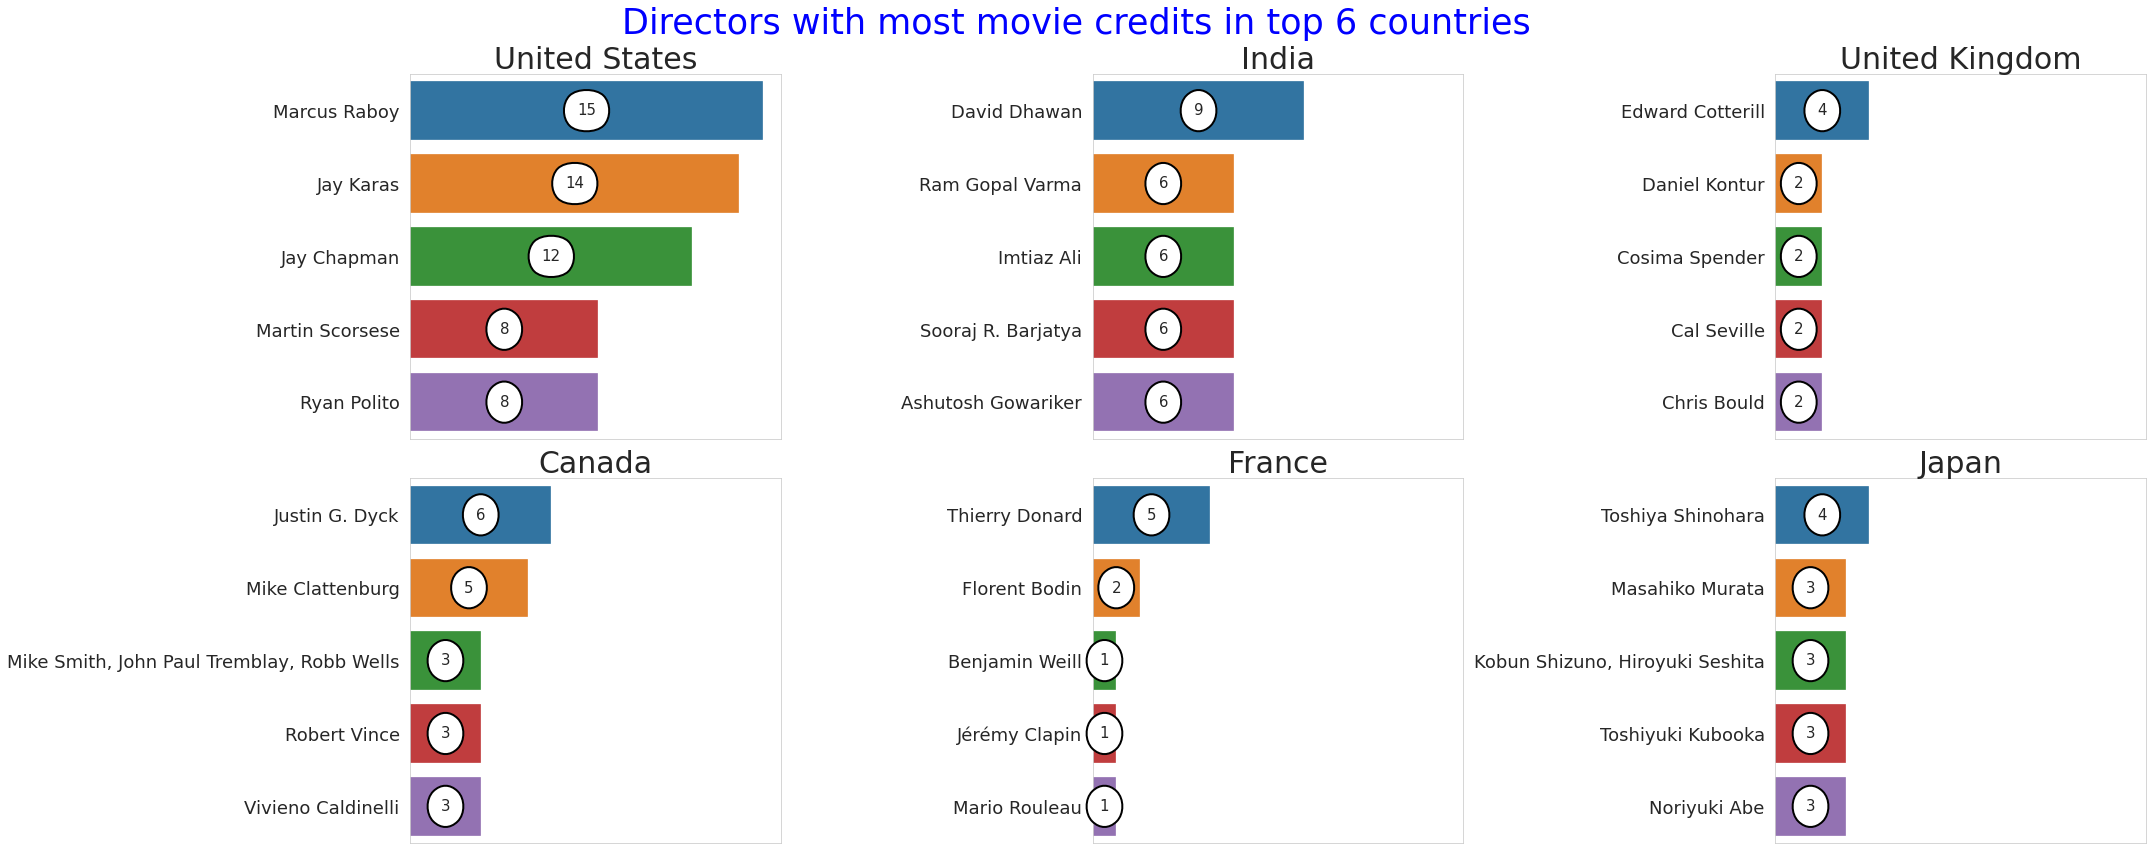

In [15]:
title = 'Directors with most movie credits in top 6 countries'
df_country = pd.DataFrame()
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (30,12), sharex = True)
_ = fig.suptitle(title, fontsize = 35, color = 'blue')
i,j = 0,0
n_countries = 6
n_directors = 5
for country in df_countries.tail(n_countries).country.values[::-1]:
    t_df = df[df.country == country].groupby(['director','country'], sort = False).count().sort_values('release_year')[-n_directors:][::-1].reset_index()
    plots = sns.barplot(data=t_df,y = 'director', x = 'release_year', ax =ax[i,j])
    for bar in plots.patches:
        _ = plots.annotate(format(bar.get_width(), '.0f'), 
               (bar.get_width()/2, 
                bar.get_y() + bar.get_height() / 2), ha='center', va='center',
               size=15, xytext=(0, 0),bbox=dict(boxstyle="round4,pad=1", fc="w", ec="black", lw=2),
               textcoords='offset points')
    _ = ax[i,j].set_xticks([])
    _ = ax[i,j].set_title(country,fontsize=30)
    _ = ax[i,j].set_xlabel('')
    _ = ax[i,j].set_ylabel('')
    df_country = df_country.append(t_df)
    j += 1
    if j> n_countries/2-1:
        j = 0
        i = 1
fig.tight_layout()
plt.savefig(title+'.'+img_fmt, format = img_fmt)

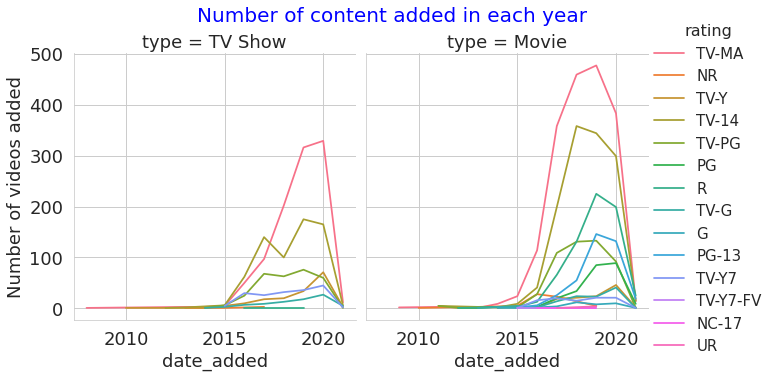

In [16]:
df_data_added = df[df.date_added >'2008-01-01'].groupby([df.date_added.dt.year,df.type,df.rating]).count().show_id.reset_index()
title = 'Number of content added in each year'
g = sns.relplot(data = df_data_added, x = 'date_added', y = 'show_id', col = 'type', hue ='rating',kind = 'line', markers = True,aspect = 0.9, height = 5)
_ = g.axes[0,0].set_ylabel('Number of videos added')
_ = g.fig.suptitle(title, color = 'blue',fontsize = 20)
_ = g.fig.subplots_adjust(top=0.85)
_ = plt.savefig(title+'.'+img_fmt,format = img_fmt)

<div style="color:#001724;
           display:fill;
           border-radius:50px;
            border-style: solid;
            padding: 25px 25px;
           border-width: 15px;
            border-color:#001724;
           background-color:#d0e7f5;
           letter-spacing:1.1px;
            font-family:'Futura';
            line-height: 1.7em;
            font-size:1.3em;">
    <h3 style = "line-height:1.3;">TV-MA and TV-14 accounts for the most number videos over the span of last 5 years.</h3>
</div>

## Converting the multi value columns from the type String to List

In [17]:
#mapping the multiple value cells into list type
df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip().replace(" ","_") for i in l.split(",")])
df['genres'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip().replace(" ","_") for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip().replace(" ","_") for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip().replace(" ","_") for i in l.split(",")])
df['all_features'] = df['directors'] + df['genres'] + df['actors'] + df['countries']
df['all_features'] = df['all_features'].apply(lambda x: " ".join(x))

# Identifying similar content by matching text-based features

In [18]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
def text_cleanser(text):
    stemmer = WordNetLemmatizer()
    text = ''.join([char for char in text if (char.isalpha() or char.isspace()) and char !="'"])
    text = [word.lower() for word in text.split() if word.lower() not in stopwords.words('english')]
    return [stemmer.lemmatize(word) for word in text]
sample_text = "Hello! This is me. I need to verify whether this sentence is working correctly."
print(text_cleanser(sample_text))

['hello', 'need', 'verify', 'whether', 'sentence', 'working', 'correctly']


In [20]:
df_desc = df[['show_id','description']].set_index('show_id')
df_desc['trunc_desc'] = df_desc['description'].apply(lambda x : text_cleanser(x))

In [21]:
vocabulary = {}
for words in df_desc.trunc_desc:
    for word in words:
        if word in vocabulary:
            vocabulary[word] = vocabulary[word] + 1
        else:
            vocabulary[word] = 1
df_voc = pd.DataFrame(list(vocabulary.items()),columns = ['text','count'])

(-0.5, 761.5, 609.5, -0.5)

Text(0.5, 1.0, 'Top key terms in the movie description')

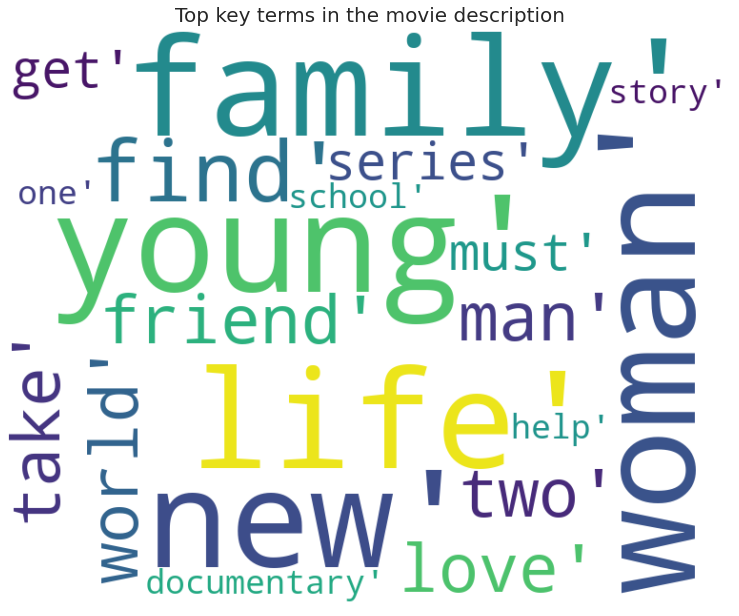

In [22]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

text = df_voc.sort_values(ascending=False, by ='count')[:20].text.values
plt.rcParams['figure.figsize'] = (13, 13)

#assigning shape to the word cloud
mask = np.array(Image.open('../input/awesome-wordcloud-masks/Awards/trophy.png'))
wordcloud = WordCloud(max_words=1000000,background_color="white",mask=mask).generate(str(text))

plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title('Top key terms in the movie description')
plt.show()

# Clustering :-

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
bow_transformer = CountVectorizer(analyzer = text_cleanser).fit(df_desc['description'])
desc_bow = bow_transformer.transform(df_desc['description'])
print('Shape of the generated matrix : ',desc_bow.shape)
sparsity = desc_bow.nnz/(desc_bow.shape[0]*desc_bow.shape[1])*100.0
print('Sparsity of the generated matrix',round(sparsity,4))

Shape of the generated matrix :  (7787, 17084)
Sparsity of the generated matrix 0.0835


In [24]:
# Finding TF and IDF metrics
vector = TfidfVectorizer(max_df=1.4, min_df=1,strip_accents = 'ascii', stop_words='english',lowercase=True,use_idf=True,norm=u'l2',smooth_idf=True)
tfidf = vector.fit_transform(df.all_features)

In [25]:
# Cluster the description data using MiniBatchKMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import linear_kernel
#setting the no. of resulting clusters for kmeans
k = 400
kmeans = MiniBatchKMeans(n_clusters = k, init = 'k-means++')
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names()
request_transform = vector.transform(df['all_features'])
# new column cluster based on the description
df['cluster'] = kmeans.predict(request_transform) 

MiniBatchKMeans(n_clusters=400)

# Recommendation System :-

In [26]:
def find_similar_movies(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]  

In [27]:
G = nx.Graph(label="MOVIE")
start_time = time.time()
for i, rowi in df.iterrows():
    G.add_node(rowi['title'],key=rowi['show_id'],label="MOVIE",mtype=rowi['type'],rating=rowi['rating'])
    for element in rowi['actors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['genres']:
        G.add_node(element,label="GENRE")
        G.add_edge(rowi['title'], element, label="GENRE_IN")
    for element in rowi['directors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    for element in rowi['countries']:
        G.add_node(element,label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")
    
    indices = find_similar_movies(tfidf, i, top_n = 5)
    snode="Sim("+rowi['title'][:15].strip()+")"        
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))    

 finish -- 66.4295003414154 seconds --


In [28]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph, title = ""):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    sizes = []
    std_size = 500
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="MOVIE":
            colors.append('#b7ebc4')
            sizes.append(std_size*2.5)
        elif G.nodes[e]['label']=="PERSON":
            colors.append('#ebdeb7')
            sizes.append(std_size)
        elif G.nodes[e]['label']=="GENRE":
            colors.append('#f5d9ce')
            sizes.append(std_size)
        elif G.nodes[e]['label']=="COU":
            colors.append('#fac5e7')
            sizes.append(std_size*0.9)
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('#dfd4ff')
            sizes.append(std_size)
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('#cdf7e9')
            sizes.append(std_size*0.9)
    nx.draw(subgraph, with_labels=True, alpha = 0.8, node_shape = 's' ,node_size = sizes,cmap = 'Accent', font_weight='bold',node_color=colors)    
    plt.title('Recommendations after watching The video '+title+' :-')
    plt.show()

## Method get_recommendation:
* Fetch 

In [29]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="MOVIE":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    movies=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        movies.append(key) 
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)        
    return result;

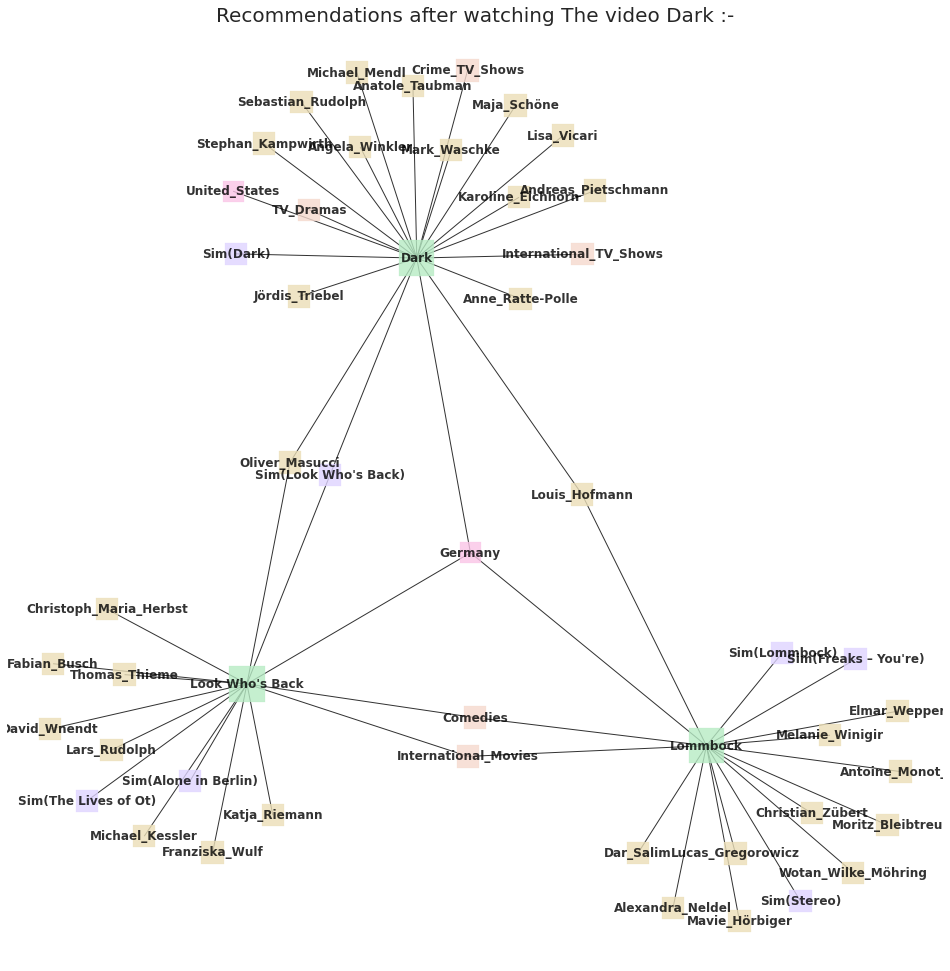

In [30]:
Movie="Dark"
recommendation = get_recommendation(Movie)
rel_graph = get_all_adj_nodes([Movie]+list(recommendation.index[:2]))
draw_sub_graph(rel_graph,Movie)

In [31]:
recommendation

Look Who's Back                            2.189724
Lommbock                                   1.631613
Isi & Ossi                                 1.631613
Clouds of Sils Maria                       1.631613
Quantum of Solace                          1.566140
                                             ...   
Harry Benson: Shoot First                  0.123445
Harvey Street Kids                         0.123445
Hatchimals | Adventures in Hatchtopia      0.123445
Haters Back Off                            0.123445
ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS    0.123445
Length: 4589, dtype: float64